In [7]:
import os
import sys
import pandas as pd
import csv

import matplotlib.pyplot as plt
from io import StringIO
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
import numpy as np
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score

cwd = os.getcwd()

# inicializácia mojich funkcií
sys.path.insert(1,cwd + '/insAInDev_Tools/')
import insAInDev_Processor as insAIProc

### Načítanie training datasetu sťažností

In [8]:
# nastavenie vizualizácie full text length
pd.set_option('display.max_colwidth', -1)

# separátor stĺpcov sa používa čiarka (pre tab to je sep='\t')
# pre moje demo požívam len prvých 100000 záznamov (nrows=100000). Pre načítanie všetkych riadkov stačí tento parameter vynechať
df = pd.read_csv(cwd + '/Datasets/Complaints/complaints.csv',sep=',', error_bad_lines=False, nrows=100000)
# zobrazenie prvých 3 riadkov 
df.head(3)

# zobrazenie popisu dataframeu
print(df.describe)

<ipython-input-8-48d29e58900d>:2: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


<bound method NDFrame.describe of       Date received  \
0      2019-09-24     
1      2019-09-19     
2      2019-11-08     
3      2019-09-15     
4      2021-01-27     
...           ...     
99995  2019-05-19     
99996  2019-08-01     
99997  2019-07-16     
99998  2019-08-14     
99999  2019-06-06     

                                                                            Product  \
0      Debt collection                                                                
1      Credit reporting, credit repair services, or other personal consumer reports   
2      Debt collection                                                                
3      Debt collection                                                                
4      Credit reporting, credit repair services, or other personal consumer reports   
...                                                                             ...   
99995  Credit reporting, credit repair services, or other personal consumer repo

### Príprava datasetu s konkrétnymi stĺpcami

In [9]:
# pomenovanie stĺpcov z datasetu
col = ['Product', 'Consumer complaint narrative']
# pridelenie stĺpcov z dataframeu
df = df[col]
# úprava datasetu (vymazanie riadkov s prázdnym textom)
df = df[pd.notnull(df['Consumer complaint narrative'])]
# definovanie konkrtétnych stĺpcov z dataframeu
df.columns = ['Product', 'Consumer_complaint_narrative']

# encoding stĺpcu Product 
df['cat_id'] = df['Product'].factorize()[0]
# zmazanie všetkych duplicitných záznamov medzi Product a cat_id
category_id_df = df[['Product', 'cat_id']].drop_duplicates().sort_values('cat_id')
# pridanie hodnôť kategórii do dictionary
category_to_id = dict(category_id_df.values)
# pridanie hodnôt do dataframeu
id_to_category = dict(category_id_df[['cat_id', 'Product']].values)
# zobrazenie prvých 3 riadkov z dataframeu
df.head(3)

,Product,Consumer_complaint_narrative,cat_id
0,Debt collection,"transworld systems inc. \nis trying to collect a debt that is not mine, not owed and is inaccurate.",0
2,Debt collection,"Over the past 2 weeks, I have been receiving excessive amounts of telephone calls from the company listed in this complaint. The calls occur between XXXX XXXX and XXXX XXXX to my cell and at my job. The company does not have the right to harass me at work and I want this to stop. It is extremely distracting to be told 5 times a day that I have a call from this collection agency while at work.",0
3,Debt collection,"Pioneer has committed several federal violations against me, a Private law abiding Federally Protected Consumer. Each violation is a statutory cost of {$1000.00} each, which does not include my personal cost and fees which shall be determined for taking time to address these issues. Violations committed against me include but not limited to : ( 1 ) Violated 15 USC 1692c ( a ) ; Communication without prior consent, expressed permission. ( 2 ) Violated 15 USC 1692d ; Harass and oppressive use of intercourse about an alleged debt. ( 3 ) Violated 15 USC 1692d ( l ) ; Attacking my reputation, accusing me of owing an alleged debt to you. ( 4 ) Violated 15 USC 1692e ( 9 ) ; Use/distribution of communication with authorization or approval. ( 5 ) Violated 15 USC 1692f ( l ) ; Attempting to collect a debt unauthorized by an agreement between parties.",0


### Vizualizácia v grafe

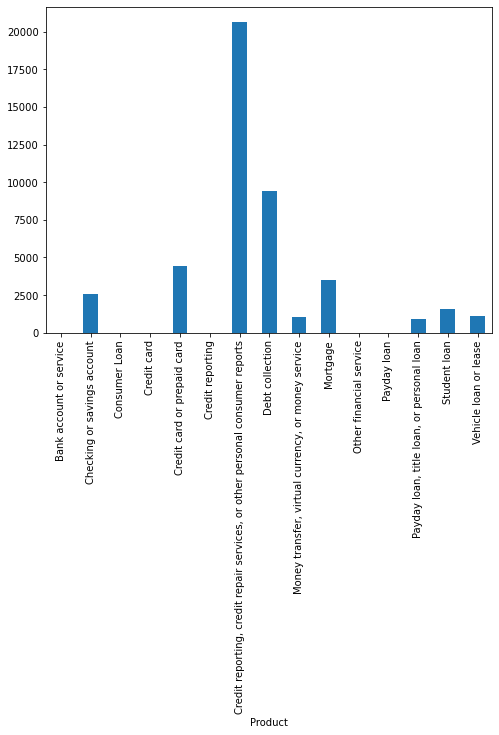

In [4]:
fig = plt.figure(figsize=(8,6))
df.groupby('Product').Consumer_complaint_narrative.count().plot.bar(ylim=0)
plt.show()

### TfidfVectorizer

In [10]:
# inicializácia modelu s nastaveniami
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')
# inicializácia features
features = tfidf.fit_transform(df.Consumer_complaint_narrative).toarray()
# inicializácia labels
labels = df.cat_id
# zobrazenie matice features
print(features.shape)

(45215, 109967)


### Korelácia výrazov s kategóriami

In [6]:
# N = 2
# for Product, category_id in sorted(category_to_id.items()):
#   features_chi2 = chi2(features, labels == category_id)
#   indices = np.argsort(features_chi2[0])
#   feature_names = np.array(tfidf.get_feature_names())[indices]
#   unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
#   bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
#   print("# '{}':".format(Product))
#   print("  . Najviac korelované Unigramy:\n. {}".format('\n. '.join(unigrams[-N:])))
#   print("  . Najviac korelované Bigramy:\n. {}".format('\n. '.join(bigrams[-N:])))

### Rozdelenie datasetu na training a test

In [11]:
# Tokenizing, odstránenie stop words a normalizácia
X = []
for doc in df.Consumer_complaint_narrative:
    X.append(insAIProc.preprocess(doc).lower())

y = df.Product

# rozdelenie datasetu na training a test
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0, test_size=0.20)


# X_train, X_test, y_train, y_test = train_test_split(df['Consumer_complaint_narrative'], df['Product'], random_state = 0, test_size=0.20)
# inicializácia vectorizéra
count_vect = CountVectorizer()
# transformácia training datasetu
X_train_counts = count_vect.fit_transform(X_train)
# interpretácia zoznamu vektorov
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

KeyboardInterrupt: 

### Multiclass klasifikátor

In [8]:
# inicializácia "učenie" modelu MultinomialNB
mnbClassifier = MultinomialNB().fit(X_train_tfidf, y_train)
# predikcia s vetou, ktorá sa priamo nachádza v training datasete
print("PREDIKCIA")
print(mnbClassifier.predict(count_vect.transform(["transworld systems inc. \nis trying to collect a debt that is not mine, not owed and is inaccurate."])))
print("Extrakcia vety z datasetu")
df[df['Consumer_complaint_narrative'] == "transworld systems inc. \nis trying to collect a debt that is not mine, not owed and is inaccurate."]
# predikcia pre celý dataset
mnbPrediction = mnbClassifier.predict(count_vect.transform(X_test))
# prepočet presnosti
print('Accuracy score: {}'.format(accuracy_score(y_test, mnbPrediction)))

PREDIKCIA
['Debt collection']
Extrakcia vety z datasetu
Accuracy score: 0.6856131814663275


### Multiclass klasifikátor výber toho najlepšieho

In [ ]:
# inicializácia modelov
models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]

# crossvalidation splitting strategy
CV = 2
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
# iterácia medzi jednotlivými modelmi
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

/Users/zoltanhalasz/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"


### Vizualizácia výsledkov v grafe

In [ ]:
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

### Výsledky modelov

In [ ]:
cv_df.groupby('model_name').accuracy.mean()

# LinearSVC: 0.822890
# LogisticRegression: 0.792927
# MultinomialNB: 0.688519
# RandomForestClassifier: 0.443826

### Vyhodnotenie modelu

In [ ]:
model = LinearSVC()
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.33, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.Product.values, yticklabels=category_id_df.Product.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()